# Import Libraries

In [ ]:
!pip install git+https://github.com/KindXiaoming/pykan.git > None # None чтобы не видеть огромного вывода, что библиотека загружается

  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-etvz1hmy


In [ ]:
import torch
from kan import KAN

import random
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
# Фиксация случайных начальных условий
def seed_everything(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(1984)

# Data Preparation

In [ ]:
df = pd.read_csv("/content/bias_param_0507_OUT.csv")

In [ ]:
df = df.drop(columns=['core', 'shell', 'formula']) 
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   area/volume                                 979 non-null    float64
 1   h_range_max_koe                             979 non-null    float64
 2   Tc                                          979 non-null    float64
 3   temperature_k                               979 non-null    float64
 4   sat_em_g                                    979 non-null    float64
 5   coer_oe                                     979 non-null    float64
 6   mr (emu/g)                                  979 non-null    float64
 7   exc_bias_oe                                 979 non-null    float64
 8   exc_dir                                     979 non-null    float64
 9   ver_shift_emu_g                             979 non-null    float64
 10  ver_s_dir     

In [ ]:
# Словарь для переименования признаков
rename_dict = {
    'area/volume': 'Area to volume ratio',
    'h_range_max_koe': 'Maximum field range',
    'Tc': 'Curie temperature',
    'temperature_k': 'Experimental temperature',
    'sat_em_g': 'Saturation magnetization',
    'coer_oe': 'Coercivity',
    'mr (emu/g)': 'Remanent magnetization',
    'exc_bias_oe': 'Exchange bias shift',
    'exc_dir': 'Exchange shift direction',
    'ver_shift_emu_g': 'Vertical shift',
    'ver_s_dir': 'Vertical shift direction',
    'fc_field_t': 'Magnetic field strength',
    'sphericity': 'Sphericity',
    'max/min': 'Geometric anisotropy',
    'core_b': 'Core beta angle',
    'num_of_magn_ions': 'Magnetic ion ratio',
    'Tn-Tb/Tn': 'Temperature difference',
    'Aex': 'Exchange stiffness coefficient',
    'core_c/a': 'Core lattice ratio',
    'core_pauling_electronegativity': 'Pauling electronegativity of core',
    'shell_pauling_electronegativity': 'Pauling electronegativity of shell',
    'core_sum_vec': 'Valence electron concentration of core',
    'core_sum_work_function': 'Work function of core',
    'shell_sum_vec': 'Valence electron concentration of shell',
    'shell_sum_work_function': 'Work function of shell',
    'core_pauling_electronegativity_difference': 'Pauling electronegativity difference of core',
    'core_vec_difference': 'Valence electron concentration difference of core',
    'core_work_function_difference': 'Work function difference of core',
    'shell_pauling_electronegativity_difference': 'Pauling electronegativity difference of shell',
    'shell_vec_difference': 'Valence electron concentration difference of shell',
    'shell_work_function_difference': 'Work function difference of shell'
}

df = df.rename(columns=rename_dict)

In [ ]:
# Проверим данные
df.describe()

,Area to volume ratio,Maximum field range,Curie temperature,Experimental temperature,Saturation magnetization,Coercivity,Remanent magnetization,Exchange bias shift,Exchange shift direction,Vertical shift,...,Valence electron concentration of core,Work function of core,Valence electron concentration of shell,Work function of shell,Pauling electronegativity difference of core,Valence electron concentration difference of core,Work function difference of core,Pauling electronegativity difference of shell,Valence electron concentration difference of shell,Work function difference of shell
count,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,...,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,9.790000e+02,979.000000
mean,0.218317,36.457692,788.942901,72.999387,415.698464,2279.340897,13.128177,318.628186,0.141502,1.259763,...,698.794157,270.812372,539.941647,176.314782,2.290421,1.526309,8.942621,2.255265,1.511955e+00,8.086343
std,0.253926,23.634419,349.454907,110.867074,4974.751928,4053.992359,18.173922,405.794171,0.343329,4.774476,...,173.442290,147.822071,307.302545,124.118630,1.602428,1.355539,6.540183,1.502012,1.309873e+00,5.453118
min,0.003000,0.100000,30.000000,1.800000,0.000087,0.600000,0.000027,0.007500,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.220446e-16,0.000000
25%,0.079302,20.000000,643.000000,5.000000,7.245000,316.500000,0.560000,31.500000,0.000000,0.000000,...,621.428600,180.000000,400.000000,89.500000,0.052172,0.000000,0.117858,0.079156,-2.220446e-16,0.000000
50%,0.150000,30.000000,809.800000,10.000000,26.353000,844.300000,6.200000,127.295000,0.000000,0.067000,...,700.000000,216.428600,683.166700,201.428600,2.860376,1.495174,10.000000,2.859813,1.443376e+00,10.000000
75%,0.253787,50.000000,860.000000,100.000000,50.550000,2188.424500,20.225000,473.310000,0.000000,0.929785,...,800.000000,470.000000,750.000000,250.000000,3.128237,2.500000,12.247450,2.932331,2.037707e+00,11.547010
max,2.000000,100.000000,1661.000000,608.000000,106600.000000,59144.000000,247.960000,1670.900000,1.000000,111.360000,...,1000.000000,515.000000,1000.000000,515.000000,11.547010,11.547010,29.495760,7.071068,7.071068e+00,26.291040


In [ ]:
target_column_name = "Exchange bias shift" # Обменный сдвиг коэрцитивной силы относительно намагниченности

X = df[list(df.columns.drop([target_column_name]))]
y = df[target_column_name]

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Применение к целевой переменной
y_smooth = gaussian_filter1d(y, sigma=2)  # Настройте sigma для изменения

# Логарифмирование целевой переменной
y_log = np.log10(y_smooth)

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=1984)

# Замена нулевых значений в целевом массиве на очень маленькое значение перед логарифмированием
#y_train[y_train == 0] = 1e-5 # Эксперимент
#y_test[y_test == 0] = 1e-5

# Нормализация дескрипторов
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Логарифмирование целевого значения
#y_train = np.log10(y_train)
#y_test = np.log10(y_test)

# Преобразование данных в тензоры PyTorch
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32) #().to_numpy
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test[:, None], dtype=torch.float32) #().to_numpy

In [ ]:
print("Диапазон значений целевых до логарифмирования: ", (np.min(y), np.max(y)))
print("Диапазон значений целевых после логарифмирования: ", (np.min(np.log10(y)), np.max(np.log10(y))))

Диапазон значений целевых до логарифмирования:  (0.0074999999999931, 1670.9)
Диапазон значений целевых после логарифмирования:  (-2.1249387366086996, 3.2229504590210114)


In [ ]:
# Вывод форм данных для проверки, чтобы проверить размеры
print("Train input shape:", train_input.shape)
print("Train label shape:", train_label.shape)
print("Test input shape:", test_input.shape)
print("Test label shape:", test_label.shape)

Train input shape: torch.Size([783, 37])
Train label shape: torch.Size([783, 1])
Test input shape: torch.Size([196, 37])
Test label shape: torch.Size([196, 1])


In [ ]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Метрики Train, Test

checkpoint directory created: ./model
saving model version 0.0
Step 0: Train R² = -18.610626220703125, Train RMSE = 2.3155665397644043, Test R² = -23.210771560668945, Test RMSE = 2.338479995727539
Step 10: Train R² = -12.594132423400879, Train RMSE = 1.9279122352600098, Test R² = -15.813493728637695, Test RMSE = 1.9487597942352295
Step 20: Train R² = -7.7708940505981445, Train RMSE = 1.5485793352127075, Test R² = -9.841644287109375, Test RMSE = 1.5648651123046875
Step 30: Train R² = -3.2254867553710938, Train RMSE = 1.074855089187622, Test R² = -4.1905975341796875, Test RMSE = 1.0827745199203491
Step 40: Train R² = -0.6388421058654785, Train RMSE = 0.6693913340568542, Test R² = -0.8987900018692017, Test RMSE = 0.6548891663551331
Step 50: Train R² = 0.017350852489471436, Train RMSE = 0.5183352828025818, Test R² = 0.0042032599449157715, Test RMSE = 0.4742580056190491
Step 60: Train R² = 0.15013891458511353, Train RMSE = 0.48204267024993896, Test R² = 0.0967721939086914, Test RMSE = 0.451

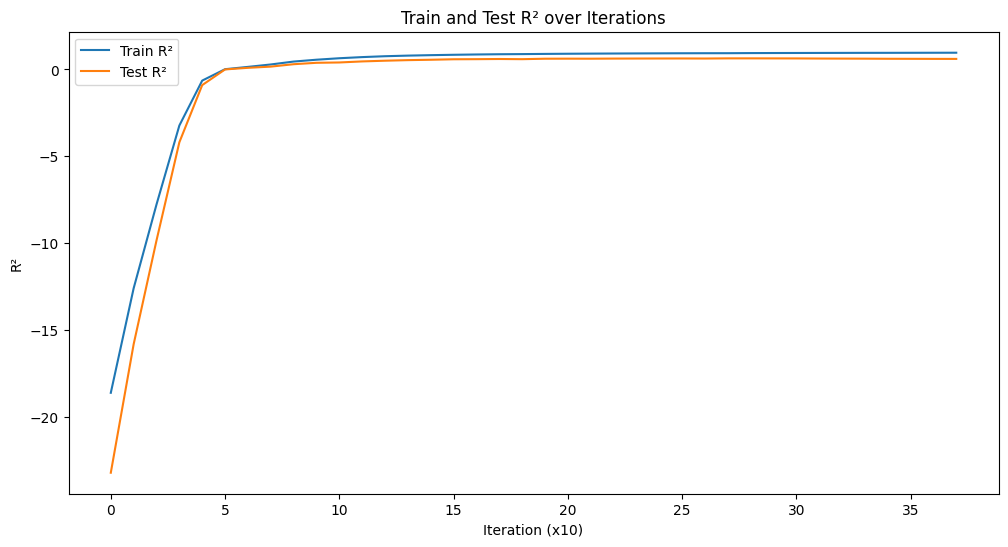

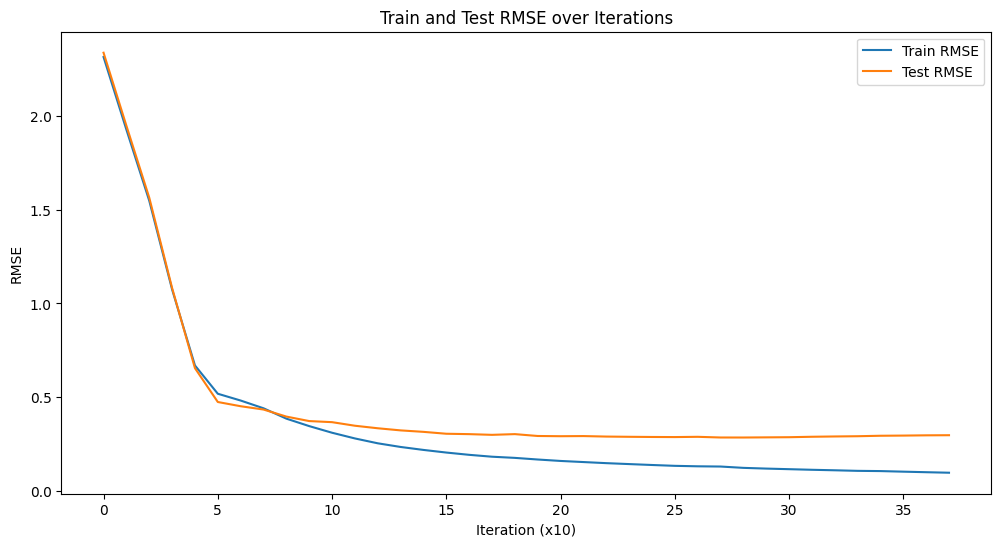

In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import random

# Фиксация случайных чисел
def set_seed(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1984)

# Найденные параметры
best_grid = 22
best_k = 15
best_width = [36, 19, 10, 1]  # Добавляем [36] в начало и [1] в конец

# Инициализация модели с лучшими параметрами
best_model = KAN(width=best_width, grid=best_grid, k=best_k)

# Использование оптимизатора Adam
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.00115)

# Шаг 2: Обучение модели с ранней остановкой и сохранением метрик
def train_with_early_stopping(model, train_input, train_label, test_input, test_label, optimizer, steps, target_r2=0.7):
    best_r2 = -np.inf  # Изначально лучший R² = -inf
    train_r2_history = []
    train_rmse_history = []
    test_r2_history = []
    test_rmse_history = []

    for step in range(steps):
        optimizer.zero_grad()
        output = model(train_input)
        loss = torch.nn.MSELoss()(output, train_label)
        loss.backward()
        optimizer.step()

        # Проверка метрик на тренировочной и тестовой выборках каждые 10 шагов
        if step % 10 == 0:
            with torch.no_grad():
                # Предсказания на тренировочной выборке
                train_output = model(train_input)
                train_preds = train_output.detach().numpy()
                train_r2 = r2_score(train_label.numpy(), train_preds)
                train_rmse = np.sqrt(mean_squared_error(train_label.numpy(), train_preds))

                # Предсказания на тестовой выборке
                test_output = model(test_input)
                test_preds = test_output.detach().numpy()
                test_r2 = r2_score(test_label.numpy(), test_preds)
                test_rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

                # Сохранение метрик
                train_r2_history.append(train_r2)
                train_rmse_history.append(train_rmse)
                test_r2_history.append(test_r2)
                test_rmse_history.append(test_rmse)

                print(f"Step {step}: Train R² = {train_r2}, Train RMSE = {train_rmse}, Test R² = {test_r2}, Test RMSE = {test_rmse}")

                # Проверка на наилучший результат по R² на тестовой выборке
                if test_r2 > best_r2:
                    best_r2 = test_r2

                # Ранняя остановка, если достигнут желаемый R²
                if best_r2 >= target_r2:
                    print(f"Reached desired R² of {target_r2} at step {step}. Stopping early.")
                    break

    return model, train_r2_history, train_rmse_history, test_r2_history, test_rmse_history

# Шаг 3: Обучение модели с ранней остановкой на 500 шагах
trained_model, train_r2_history, train_rmse_history, test_r2_history, test_rmse_history = train_with_early_stopping(
    best_model, train_input, train_label, test_input, test_label, optimizer, steps=380
)

# Шаг 4: Финальная оценка на тестовых данных
with torch.no_grad():
    test_preds = trained_model(test_input).detach().numpy()
    final_test_r2 = r2_score(test_label.numpy(), test_preds)
    final_test_rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

print(f"Final R² on test set: {final_test_r2}")
print(f"Final RMSE on test set: {final_test_rmse}")

# Шаг 5: Визуализация метрик по шагам
plt.figure(figsize=(12, 6))
plt.plot(train_r2_history, label='Train R²')
plt.plot(test_r2_history, label='Test R²')
plt.title('Train and Test R² over Iterations')
plt.xlabel('Iteration (x10)')
plt.ylabel('R²')
plt.legend()
plt.grid(False)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(test_rmse_history, label='Test RMSE')
plt.title('Train and Test RMSE over Iterations')
plt.xlabel('Iteration (x10)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(False)
plt.show()

# Scatter plot: KAN predicted vs actual

<ipython-input-19-33ea540d4a08>:34: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(ideal_line, ideal_line + final_test_rmse, 'b--', label=f'RMSE bound', linestyle=':')
<ipython-input-19-33ea540d4a08>:35: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(ideal_line, ideal_line - final_test_rmse, 'b--', linestyle=':')


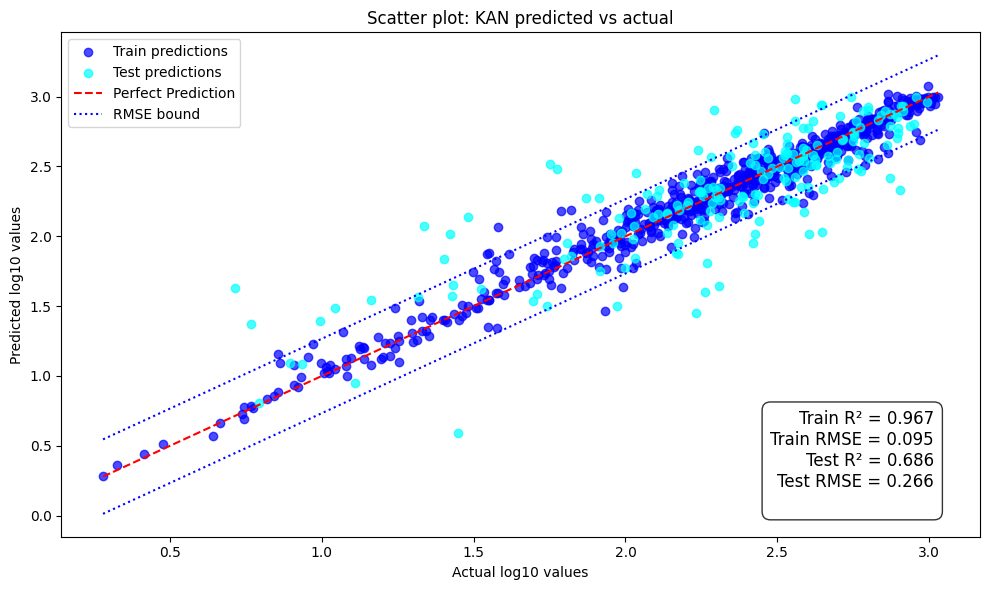

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Получение предсказаний на тренировочной выборке
with torch.no_grad():
    train_preds = trained_model(train_input).detach().numpy()
    test_preds = trained_model(test_input).detach().numpy()

# Финальные метрики
final_train_r2 = r2_score(train_label.numpy(), train_preds)
final_train_rmse = np.sqrt(mean_squared_error(train_label.numpy(), train_preds))
final_test_r2 = r2_score(test_label.numpy(), test_preds)
final_test_rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

# Визуализация предсказанных и реальных значений для Train и Test с линиями RMSE
plt.figure(figsize=(10, 6))

# Минимальные и максимальные значения для графика
min_val = min(min(test_label.numpy()), min(train_label.numpy()))
max_val = max(max(test_label.numpy()), max(train_label.numpy()))

# Scatter Plot: Train Data (синие точки)
plt.scatter(train_label.numpy(), train_preds, alpha=0.7, color='blue', label='Train predictions')

# Scatter Plot: Test Data (светло-синие точки)
plt.scatter(test_label.numpy(), test_preds, alpha=0.7, color='cyan', label='Test predictions')

# Идеальная линия предсказания (красная пунктирная линия)
ideal_line = np.linspace(min_val, max_val, 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Perfect Prediction')

# Линии RMSE для тестовой выборки
plt.plot(ideal_line, ideal_line + final_test_rmse, 'b--', label=f'RMSE bound', linestyle=':')
plt.plot(ideal_line, ideal_line - final_test_rmse, 'b--', linestyle=':')

# Финальные метрики для теста и тренировки
metrics_text = (
    f'Train R² = {final_train_r2:.3f}\n'
    f'Train RMSE = {final_train_rmse:.3f}\n'
    f'Test R² = {final_test_r2:.3f}\n'
    f'Test RMSE = {final_test_rmse:.3f}\n'
)

# Добавление текста с метриками
plt.text(0.95, 0.05, metrics_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='black'))

# Оформление графика
plt.title('Scatter plot: KAN predicted vs actual')
plt.xlabel('Actual log10 values')
plt.ylabel('Predicted log10 values')
plt.legend(loc='upper left')

# Показать график
plt.tight_layout()
plt.show()

# Метрики для кроссвалидации и валидации

In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import random

# Фиксация случайных чисел
def set_seed(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1984)

# Разделение train_input на тренировочную и валидационную выборку
train_input, val_input, train_label, val_label = train_test_split(train_input, train_label, test_size=0.125, random_state=1984)

# Кросс-валидация на 5 фолдах
kf = KFold(n_splits=5, shuffle=True, random_state=1984)

# Найденные параметры
best_grid = 22
best_k = 15
best_width = [36, 19, 10, 1]

# Функция для обучения модели
def train_with_cross_validation(model, train_input, train_label, val_input, val_label, optimizer, steps):
    # Инициализация метрик
    best_r2 = -np.inf
    final_val_r2 = None
    final_val_rmse = None

    for train_index, val_index in kf.split(train_input):
        fold_train_input = train_input[train_index]
        fold_train_label = train_label[train_index]
        fold_val_input = train_input[val_index]
        fold_val_label = train_label[val_index]

        for step in range(steps):
            optimizer.zero_grad()
            output = model(fold_train_input)
            loss = torch.nn.MSELoss()(output, fold_train_label)
            loss.backward()
            optimizer.step()

        # После завершения всех шагов на фолде, вычисляем метрики для валидации
        with torch.no_grad():
            val_output = model(fold_val_input)
            val_preds = val_output.detach().numpy()
            final_val_r2 = r2_score(fold_val_label.numpy(), val_preds)
            final_val_rmse = np.sqrt(mean_squared_error(fold_val_label.numpy(), val_preds))

            # Проверка на лучший результат по R²
            if final_val_r2 > best_r2:
                best_r2 = final_val_r2

    print(f"Final validation R² = {final_val_r2}, Final validation RMSE = {final_val_rmse}")
    return model

# Инициализация модели с лучшими параметрами
best_model = KAN(width=best_width, grid=best_grid, k=best_k)

# Оптимизатор
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.00115)

# Обучение модели с кросс-валидацией
trained_model = train_with_cross_validation(
    best_model, train_input, train_label, val_input, val_label, optimizer, steps=380)

# Финальная оценка на валидационных данных
with torch.no_grad():
    val_preds = trained_model(val_input).detach().numpy()
    final_val_r2 = r2_score(val_label.numpy(), val_preds)
    final_val_rmse = np.sqrt(mean_squared_error(val_label.numpy(), val_preds))

print(f"Final R² on validation set: {final_val_r2}")
print(f"Final RMSE on validation set: {final_val_rmse}")

checkpoint directory created: ./model
saving model version 0.0
Final validation R² = 0.9783521890640259, Final validation RMSE = 0.07644045352935791
Final R² on validation set: 0.22205644845962524
Final RMSE on validation set: 0.4984898865222931


## Проверка Step 380: R² = 0.6833

In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import random

# Фиксация случайных чисел
def set_seed(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1984)

# Предполагается, что KAN, train_input, train_label, test_input, test_label уже определены

# Найденные параметры
best_grid = 22
best_k = 15
best_width = [36, 19, 10, 1]  # Добавляем [36] в начало и [1] в конец

# Инициализация модели с лучшими параметрами
best_model = KAN(width=best_width, grid=best_grid, k=best_k)

# Использование оптимизатора Adam (такой как в процессе поиска Optuna)
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.00115)

# Функция для обучения модели с ранней остановкой
def train_with_early_stopping(model, train_input, train_label, test_input, test_label, optimizer, steps, target_r2=0.7):
    best_r2 = -np.inf  # Изначально лучший R² = -inf

    for step in range(steps):
        optimizer.zero_grad()
        output = model(train_input)
        loss = torch.nn.MSELoss()(output, train_label)
        loss.backward()
        optimizer.step()

        # Проверяем R² на тесте каждые 10 шагов
        if step % 10 == 0:
            with torch.no_grad():
                test_output = model(test_input)
                test_preds = test_output.detach().numpy()
                r2 = r2_score(test_label.numpy(), test_preds)
                print(f"Step {step}: R² = {r2}")

                if r2 > best_r2:
                    best_r2 = r2

                # Ранняя остановка, если достигнут желаемый R²
                if best_r2 >= target_r2:
                    print(f"Reached desired R² of {target_r2} at step {step}. Stopping early.")
                    break

    return model

# Обучение модели (270 шагов с ранней остановкой)
trained_model = train_with_early_stopping(best_model, train_input, train_label, test_input, test_label, optimizer, steps=500)

# Оценка на тестовых данных
with torch.no_grad():
    test_preds = trained_model(test_input).detach().numpy()
    best_r2 = r2_score(test_label.numpy(), test_preds)
    best_rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

print(f"Final R² on test set: {best_r2}")
print(f"Final RMSE on test set: {best_rmse}")

checkpoint directory created: ./model
saving model version 0.0
Step 0: R² = -23.210226912810864
Step 10: R² = -15.833164916983662
Step 20: R² = -9.041570546880177
Step 30: R² = -4.716498619726252
Step 40: R² = -1.4524157808769487
Step 50: R² = -0.05990010466913498
Step 60: R² = 0.042054602444629885
Step 70: R² = 0.19826603430017786
Step 80: R² = 0.311116164648471
Step 90: R² = 0.3547802848307442
Step 100: R² = 0.3750700872661382
Step 110: R² = 0.4127332658802819
Step 120: R² = 0.4539549080187453
Step 130: R² = 0.48895770659958304
Step 140: R² = 0.5187086125099012
Step 150: R² = 0.5390013076389519
Step 160: R² = 0.5565663674689236
Step 170: R² = 0.5686450203034034
Step 180: R² = 0.5752492923712769
Step 190: R² = 0.5821128356092842
Step 200: R² = 0.5935795089531506
Step 210: R² = 0.6064631455392333
Step 220: R² = 0.6181193847105554
Step 230: R² = 0.6300897852009149
Step 240: R² = 0.6403578878824482
Step 250: R² = 0.6561921578889753
Step 260: R² = 0.6656074774617288
Step 270: R² = 0.66547

# SHAP

In [ ]:
!pip install shap

In [ ]:
# Фиксация случайных начальных условий
def seed_everything(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(1984)

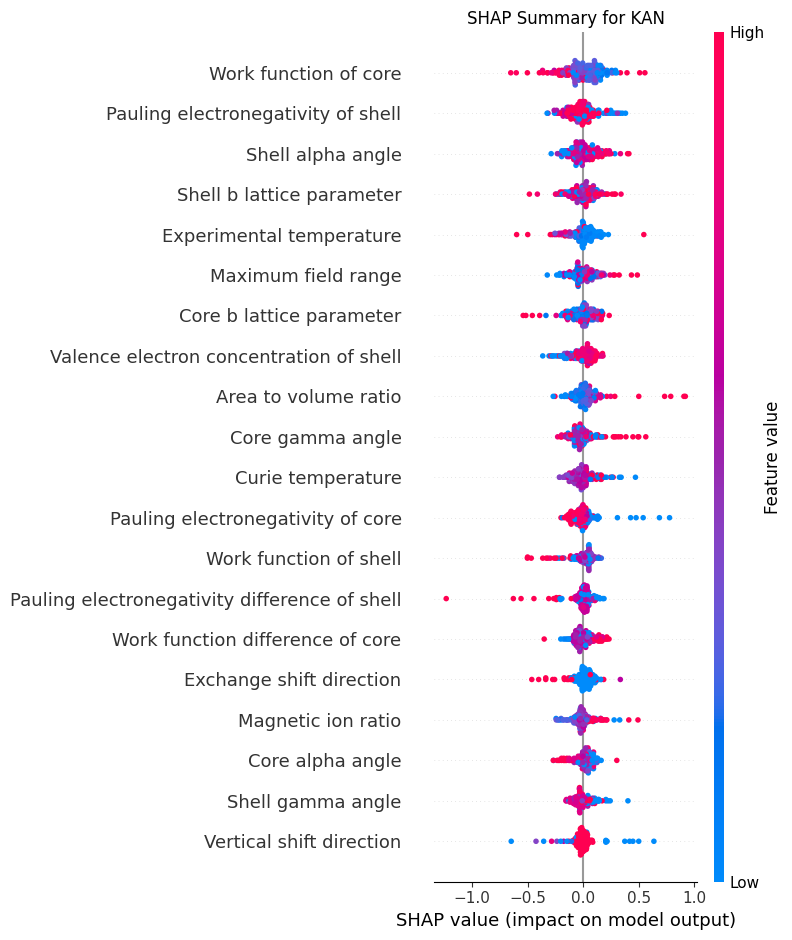

In [ ]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

# Переход в режим оценки модели
best_model.eval()

# Преобразование входных данных в формат numpy
X_train_np = train_input.detach().cpu().numpy()
X_test_np = test_input.detach().cpu().numpy()

# Словарь для переименования признаков по исходным названиям
rename_dict = {
    'area/volume': 'Area to volume ratio',
    'h_range_max_koe': 'Maximum field range',
    'Tc': 'Curie temperature',
    'temperature_k': 'Experimental temperature',
    'sat_em_g': 'Saturation magnetization',
    'coer_oe': 'Coercivity',
    'mr (emu/g)': 'Remanent magnetization',
    'exc_dir': 'Exchange shift direction',
    'ver_shift_emu_g': 'Vertical shift',
    'ver_s_dir': 'Vertical shift direction',
    'fc_field_t': 'Magnetic field strength',
    'sphericity': 'Sphericity',
    'max/min': 'Geometric anisotropy',
    'core_b': 'Core b lattice parameter',
    'core_alpha': 'Core alpha angle',
    'core_beta': 'Core beta angle',
    'core_gamma': 'Core gamma angle',
    'shell_b': 'Shell b lattice parameter',
    'shell_alpha': 'Shell alpha angle',
    'shell_beta': 'Shell beta angle',
    'shell_gamma': 'Shell gamma angle',
    'num_of_magn_ions': 'Magnetic ion ratio',
    'Tn-Tb/Tn': 'Temperature difference',
    'Aex': 'Exchange stiffness coefficient',
    'core_c/a': 'Core lattice ratio с to a',
    'core_pauling_electronegativity': 'Pauling electronegativity of core',
    'shell_pauling_electronegativity': 'Pauling electronegativity of shell',
    'core_sum_vec': 'Valence electron concentration of core',
    'core_sum_work_function': 'Work function of core',
    'shell_sum_vec': 'Valence electron concentration of shell',
    'shell_sum_work_function': 'Work function of shell',
    'core_pauling_electronegativity_difference': 'Pauling electronegativity difference of core',
    'core_vec_difference': 'Valence electron concentration difference of core',
    'core_work_function_difference': 'Work function difference of core',
    'shell_pauling_electronegativity_difference': 'Pauling electronegativity difference of shell',
    'shell_vec_difference': 'Valence electron concentration difference of shell',
    'shell_work_function_difference': 'Work function difference of shell'
}

# Переход в режим оценки модели
best_model.eval()

# Преобразование входных данных в формат numpy
X_train_np = train_input.detach().cpu().numpy()
X_test_np = test_input.detach().cpu().numpy()

# Удаление признака 'Exchange bias shift' (exc_bias_oe)
exclude_feature = 'exc_bias_oe'
feature_names = list(rename_dict.keys())  # Список исходных имен признаков
exclude_index = [i for i, feature in enumerate(feature_names) if feature == exclude_feature]

# Удаление признака из данных и списка имен
if exclude_index:
    X_train_np = np.delete(X_train_np, exclude_index, axis=1)
    X_test_np = np.delete(X_test_np, exclude_index, axis=1)
    feature_names = [f for i, f in enumerate(feature_names) if i not in exclude_index]

# Преобразование данных обратно в тензоры для SHAP
train_tensor = torch.tensor(X_train_np, dtype=torch.float)
test_tensor = torch.tensor(X_test_np, dtype=torch.float)

# Создаем SHAP объяснитель
explainer = shap.GradientExplainer(best_model, train_tensor)

# Вычисляем SHAP значения для тестовых данных
shap_values = explainer.shap_values(test_tensor)

# Преобразуем SHAP значения в numpy array
if isinstance(shap_values, list):
    shap_values_np = np.array(shap_values[0])  # Используем первый элемент для регрессии
else:
    shap_values_np = np.array(shap_values)

# Если SHAP значения многомерные (samples, features, outputs), усредняем по выходам
if shap_values_np.ndim == 3:
    shap_values_np = shap_values_np.mean(axis=2)

# Переименование признаков с использованием словаря
feature_names_renamed = [rename_dict.get(f, f) for f in feature_names]

# Проверка корректности длины имен признаков
if len(feature_names_renamed) != X_test_np.shape[1]:
    raise ValueError("The number of renamed features does not match the number of features in the data.")

# Создание фигуры и оси перед построением графика SHAP
plt.figure(figsize=(10, 6))

# Построение SHAP summary plot с переименованными признаками
shap.summary_plot(shap_values_np, X_test_np, feature_names=feature_names_renamed, show=False)

# Добавление заголовка через matplotlib
plt.title("SHAP Summary for KAN")
plt.tight_layout()  # Для предотвращения обрезки графика
plt.show()

# SHAP сравнение

Training XGB...


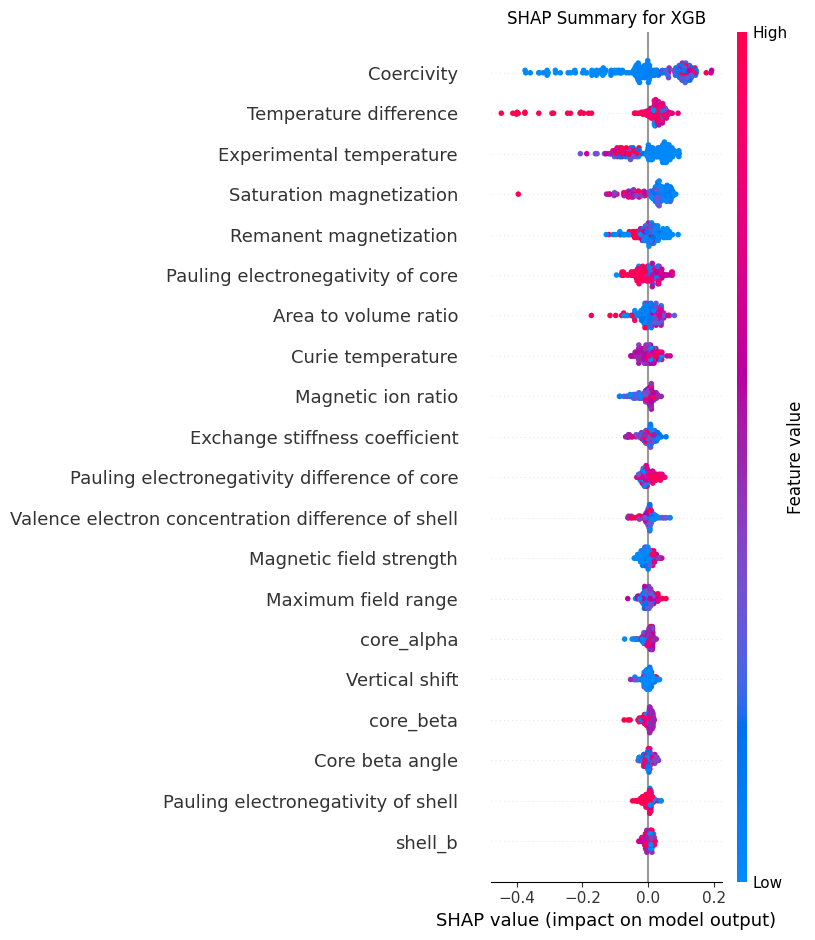

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from scipy.ndimage import gaussian_filter1d

# Загрузка данных
df = pd.read_csv('/content/bias_param_0507_OUT.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# Dictionary for renaming columns
rename_dict = {
    'area/volume': 'Area to volume ratio',
    'h_range_max_koe': 'Maximum field range',
    'Tc': 'Curie temperature',
    'temperature_k': 'Experimental temperature',
    'sat_em_g': 'Saturation magnetization',
    'coer_oe': 'Coercivity',
    'mr (emu/g)': 'Remanent magnetization',
    'exc_bias_oe': 'Exchange bias shift',
    'exc_dir': 'Exchange shift direction',
    'ver_shift_emu_g': 'Vertical shift',
    'ver_s_dir': 'Vertical shift direction',
    'fc_field_t': 'Magnetic field strength',
    'sphericity': 'Sphericity',
    'max/min': 'Geometric anisotropy',
    'core_b': 'Core beta angle',
    'num_of_magn_ions': 'Magnetic ion ratio',
    'Tn-Tb/Tn': 'Temperature difference',
    'Aex': 'Exchange stiffness coefficient',
    'core_c/a': 'Core lattice ratio',
    'core_pauling_electronegativity': 'Pauling electronegativity of core',
    'shell_pauling_electronegativity': 'Pauling electronegativity of shell',
    'core_sum_vec': 'Valence electron concentration of core',
    'core_sum_work_function': 'Work function of core',
    'shell_sum_vec': 'Valence electron concentration of shell',
    'shell_sum_work_function': 'Work function of shell',
    'core_pauling_electronegativity_difference': 'Pauling electronegativity difference of core',
    'core_vec_difference': 'Valence electron concentration difference of core',
    'core_work_function_difference': 'Work function difference of core',
    'shell_pauling_electronegativity_difference': 'Pauling electronegativity difference of shell',
    'shell_vec_difference': 'Valence electron concentration difference of shell',
    'shell_work_function_difference': 'Work function difference of shell'
}

# Переименование столбцов
df = df.rename(columns=rename_dict)

# Предварительная обработка
y = df['Exchange bias shift']
y = y[y > 0]  # Фильтрация только положительных значений

# Применение сглаживания к целевой переменной
y_smooth = gaussian_filter1d(y, sigma=2)  # Настройте sigma для изменения степени сглаживания

# Логарифмирование сглаженной целевой переменной
y_log = np.log10(y_smooth)

# Формирование признаков
X = df[df['Exchange bias shift'] > 0].drop(columns=['Exchange bias shift'])

# Применение KNN Imputer для заполнения пропущенных значений
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = knn_imputer.fit_transform(X)

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_log, test_size=0.2, random_state=1984)

# Масштабирование данных
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Определение модели XGB
model = XGBRegressor(
    n_estimators=424, max_depth=22, learning_rate=0.029775486467142665,
    subsample=0.7358573421632647, colsample_bytree=0.5128835927539236, gamma=0.001178216687382395,
    reg_alpha=0.3688362981967942, reg_lambda=0.9581849266893232, min_child_weight=4,
    scale_pos_weight=9.787498596663324, random_state=1984
)

# Обучение модели
print('Training XGB...')
model.fit(X_train_scaled, y_train)

# SHAP значения и построение графиков
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# Построение SHAP-графиков для топ-6 признаков
plt.title('SHAP Summary for XGB')
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)
plt.show()

In [ ]:
df.columns

Index(['area/volume', 'h_range_max_koe', 'Tc', 'temperature_k', 'sat_em_g',
       'coer_oe', 'mr (emu/g)', 'exc_bias_oe', 'exc_dir', 'ver_shift_emu_g',
       'ver_s_dir', 'fc_field_t', 'sphericity', 'max/min', 'core_b',
       'core_alpha', 'core_beta', 'core_gamma', 'shell_b', 'shell_alpha',
       'shell_beta', 'shell_gamma', 'num_of_magn_ions', 'Tn-Tb/Tn', 'Aex',
       'core_c/a', 'core_pauling_electronegativity',
       'shell_pauling_electronegativity', 'core_sum_vec',
       'core_sum_work_function', 'shell_sum_vec', 'shell_sum_work_function',
       'core_pauling_electronegativity_difference', 'core_vec_difference',
       'core_work_function_difference',
       'shell_pauling_electronegativity_difference', 'shell_vec_difference',
       'shell_work_function_difference'],
      dtype='object')

In [ ]:
import torch
import random
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from scipy.ndimage import gaussian_filter1d

# Установка фиксированного seed
def set_seed(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1984)

# Загрузка и обработка данных
df = pd.read_csv('/content/bias_param_0507_OUT.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# Словарь для переименования признаков
rename_dict = {
    'area/volume': 'Area to volume ratio',
    'h_range_max_koe': 'Maximum field range',
    'Tc': 'Curie temperature',
    'temperature_k': 'Experimental temperature',
    'sat_em_g': 'Saturation magnetization',
    'coer_oe': 'Coercivity',
    'mr (emu/g)': 'Remanent magnetization',
    'exc_bias_oe': 'Exchange bias shift',
    'exc_dir': 'Exchange shift direction',
    'ver_shift_emu_g': 'Vertical shift',
    'ver_s_dir': 'Vertical shift direction',
    'fc_field_t': 'Magnetic field strength',
    'sphericity': 'Sphericity',
    'max/min': 'Geometric anisotropy',
    'core_b': 'Core beta angle',
    'num_of_magn_ions': 'Magnetic ion ratio',
    'Tn-Tb/Tn': 'Temperature difference',
    'Aex': 'Exchange stiffness coefficient',
    'core_c/a': 'Core lattice ratio',
    'core_pauling_electronegativity': 'Pauling electronegativity of core',
    'shell_pauling_electronegativity': 'Pauling electronegativity of shell',
    'core_sum_vec': 'Valence electron concentration of core',
    'core_sum_work_function': 'Work function of core',
    'shell_sum_vec': 'Valence electron concentration of shell',
    'shell_sum_work_function': 'Work function of shell',
    'core_pauling_electronegativity_difference': 'Pauling electronegativity difference of core',
    'core_vec_difference': 'Valence electron concentration difference of core',
    'core_work_function_difference': 'Work function difference of core',
    'shell_pauling_electronegativity_difference': 'Pauling electronegativity difference of shell',
    'shell_vec_difference': 'Valence electron concentration difference of shell',
    'shell_work_function_difference': 'Work function difference of shell'
}

df = df.rename(columns=rename_dict)

# Разделение целевой переменной и признаков
y = df['Exchange bias shift']
y = y[y > 0]  # Фильтрация только положительных значений

# Сглаживание и логарифмирование целевой переменной
y_smooth = gaussian_filter1d(y, sigma=2)
y_log = np.log10(y_smooth)

# Признаки
X = df[df['Exchange bias shift'] > 0].drop(columns=['Exchange bias shift'])

# Импьютация и масштабирование признаков
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = knn_imputer.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_log, test_size=0.2, random_state=1984)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----- XGBoost -----
print('Training XGBoost...')
model = XGBRegressor(
    n_estimators=424, max_depth=22, learning_rate=0.0298, subsample=0.7358,
    colsample_bytree=0.5129, gamma=0.00117, reg_alpha=0.3688, reg_lambda=0.9581,
    min_child_weight=4, scale_pos_weight=9.787, random_state=1984
)
model.fit(X_train_scaled, y_train)

# SHAP для XGBoost
explainer_xgb = shap.TreeExplainer(model)
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)

# ----- KAN -----

# Настройка KAN
best_width = [36, 19, 10, 1]
best_model = KAN(width=best_width, grid=22, k=15)
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.00115)

# Преобразование в тензоры
train_input = torch.tensor(X_train_scaled, dtype=torch.float)
train_label = torch.tensor(y_train, dtype=torch.float).unsqueeze(1)
test_input = torch.tensor(X_test_scaled, dtype=torch.float)
test_label = torch.tensor(y_test, dtype=torch.float).unsqueeze(1)

# Обучение KAN с ранней остановкой
def train_with_early_stopping(model, train_input, train_label, test_input, test_label, optimizer, steps=380, target_r2=0.7):
    best_r2 = -np.inf
    for step in range(steps):
        optimizer.zero_grad()
        output = model(train_input)
        loss = torch.nn.MSELoss()(output, train_label)
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            with torch.no_grad():
                test_output = model(test_input)
                test_preds = test_output.numpy()
                r2 = r2_score(test_label.numpy(), test_preds)
                print(f"Step {step}: R² = {r2}")
                if r2 > best_r2:
                    best_r2 = r2
                if best_r2 >= target_r2:
                    print(f"Stopping early at step {step} with R² = {r2}.")
                    break
    return model

# Обучение KAN
print('Training KAN...')
best_model = train_with_early_stopping(best_model, train_input, train_label, test_input, test_label, optimizer, steps=350)

# SHAP для KAN
explainer_kan = shap.GradientExplainer(best_model, train_input)
shap_values_kan = explainer_kan.shap_values(test_input)

# ----- SHAP графики -----
# SHAP для XGBoost
plt.title('SHAP Summary for XGBoost')
shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=X.columns)
plt.show()

# SHAP для KAN
plt.title('SHAP Summary for KAN')
shap.summary_plot(shap_values_kan, X_test_scaled, feature_names=X.columns)
plt.show()

Training XGBoost...
Training KAN...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (783x37 and 36x19)

Shape of SHAP values (XGB): (196, 37)
Shape of SHAP values (KAN): (196, 37, 1)


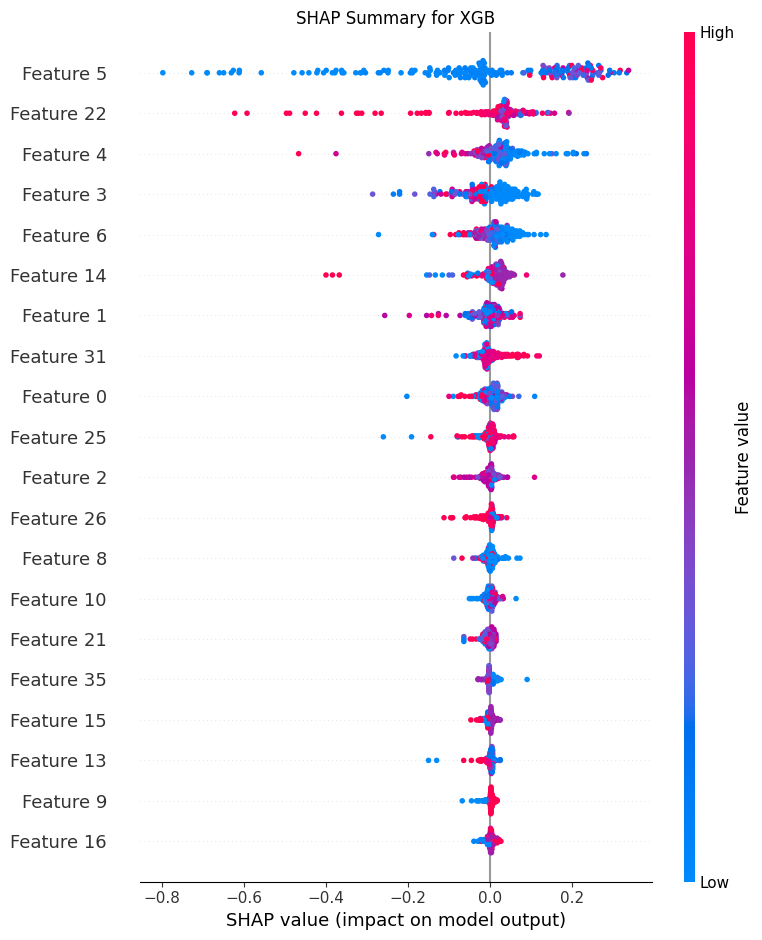

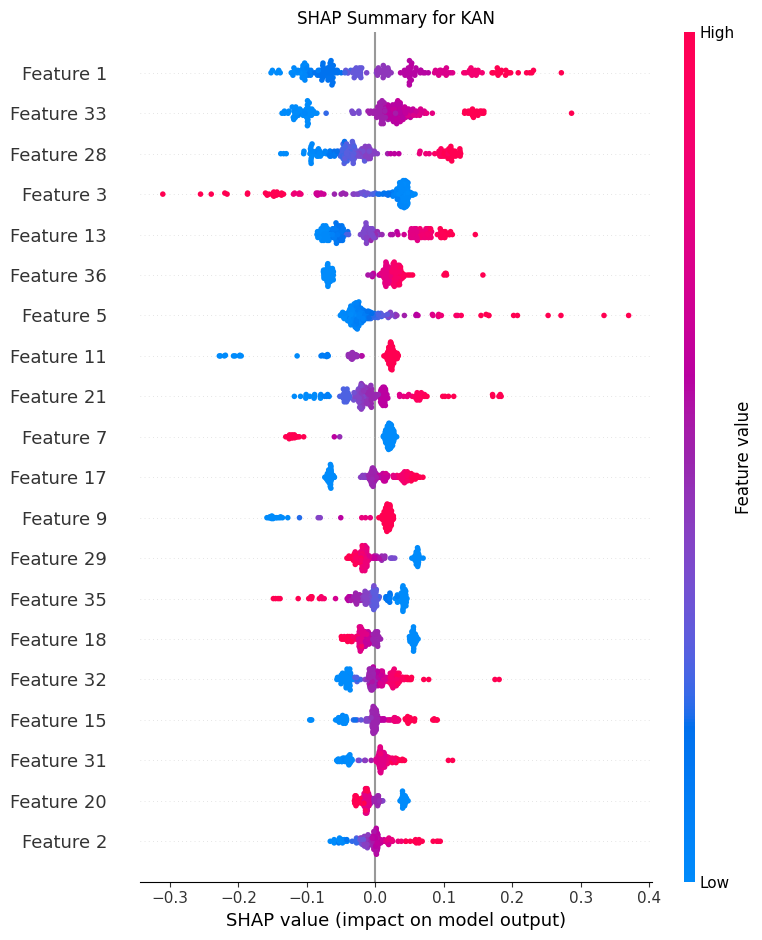

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from scipy.ndimage import gaussian_filter1d

# Загрузка данных
df = pd.read_csv('/content/bias_param_0507_OUT.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

rename_dict = {
    'area/volume': 'Area to volume ratio',
    'h_range_max_koe': 'Maximum field range',
    'Tc': 'Curie temperature',
    'temperature_k': 'Experimental temperature',
    'sat_em_g': 'Saturation magnetization',
    'coer_oe': 'Coercivity',
    'mr (emu/g)': 'Remanent magnetization',
    'exc_bias_oe': 'Exchange bias shift',
    'exc_dir': 'Exchange shift direction',
    'ver_shift_emu_g': 'Vertical shift',
    'ver_s_dir': 'Vertical shift direction',
    'fc_field_t': 'Magnetic field strength',
    'sphericity': 'Sphericity',
    'max/min': 'Geometric anisotropy',
    'core_b': 'Core b lattice parameter',
    'core_alpha': 'Core alpha angle',
    'core_beta': 'Core beta angle',
    'core_gamma': 'Core gamma angle',
    'shell_b': 'Shell b lattice parameter',
    'shell_alpha': 'Shell alpha angle',
    'shell_beta': 'Shell beta angle',
    'shell_gamma': 'Shell gamma angle',
    'num_of_magn_ions': 'Magnetic ion ratio',
    'Tn-Tb/Tn': 'Temperature difference',
    'Aex': 'Exchange stiffness coefficient',
    'core_c/a': 'Core lattice ratio с to a',
    'core_pauling_electronegativity': 'Pauling electronegativity of core',
    'shell_pauling_electronegativity': 'Pauling electronegativity of shell',
    'core_sum_vec': 'Valence electron concentration of core',
    'core_sum_work_function': 'Work function of core',
    'shell_sum_vec': 'Valence electron concentration of shell',
    'shell_sum_work_function': 'Work function of shell',
    'core_pauling_electronegativity_difference': 'Pauling electronegativity difference of core',
    'core_vec_difference': 'Valence electron concentration difference of core',
    'core_work_function_difference': 'Work function difference of core',
    'shell_pauling_electronegativity_difference': 'Pauling electronegativity difference of shell',
    'shell_vec_difference': 'Valence electron concentration difference of shell',
    'shell_work_function_difference': 'Work function difference of shell'
}

# Предварительная обработка
y = df['exc_bias_oe']
y = y[y > 0]  # Фильтрация только положительных значений

# Применение сглаживания к целевой переменной
y_smooth = gaussian_filter1d(y, sigma=2)  # Настройте sigma для изменения степени сглаживания

# Логарифмирование сглаженной целевой переменной
y_log = np.log10(y_smooth)

# Формирование признаков
X = df[df['exc_bias_oe'] > 0].drop(columns=['exc_bias_oe'])

# Применение KNN Imputer для заполнения пропущенных значений
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = knn_imputer.fit_transform(X)

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_log, test_size=0.2, random_state=1984)

# Масштабирование данных
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Определение модели XGB
model_xgb = XGBRegressor(n_estimators=424, max_depth=22, learning_rate=0.029)
model_xgb.fit(X_train_scaled, y_train)

# Создание и обучение модели KAN
# Здесь добавьте код для вашей нейронной сети (KAN), например, с использованием PyTorch
# Например:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleKAN(nn.Module):
    def __init__(self, input_size):
        super(SimpleKAN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 19)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Преобразование данных в тензоры
train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Убрали .values

# Обучение модели KAN
kan_model = SimpleKAN(X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(kan_model.parameters(), lr=0.01)

# Обучение модели
for epoch in range(100):  # Задайте нужное количество эпох
    kan_model.train()
    optimizer.zero_grad()
    outputs = kan_model(train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# SHAP для XGBoost
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)

# SHAP для KAN
kan_model.eval()
test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
explainer_kan = shap.GradientExplainer(kan_model, train_tensor)
shap_values_kan = explainer_kan.shap_values(test_tensor)

# Преобразование SHAP значений для KAN
if isinstance(shap_values_kan, list):
    shap_values_kan_np = np.array(shap_values_kan[0])
else:
    shap_values_kan_np = np.array(shap_values_kan)

# Проверка размерностей
print("Shape of SHAP values (XGB):", shap_values_xgb.shape)
print("Shape of SHAP values (KAN):", shap_values_kan_np.shape)

# Если SHAP значения многомерные (samples, features, outputs), усредняем по выходам
if shap_values_kan_np.ndim == 3:
    shap_values_kan_np = shap_values_kan_np.mean(axis=2)

# Определение имен признаков
feature_names = X.columns.tolist()

# Переименование признаков с использованием словаря
renamed_features = [rename_dict.get(f'Feature {i}', f'Feature {i}') for i in range(len(feature_names))]

# Удаление признака 'Exchange bias shift' (Feature 7)
exclude_feature = 'Feature 7'
exclude_index = [i for i, feature in enumerate(feature_names) if feature == exclude_feature]

if exclude_index:
    X_test_scaled = np.delete(X_test_scaled, exclude_index, axis=1)  # Удаление из тестовых данных
    shap_values_xgb = np.delete(shap_values_xgb, exclude_index, axis=1)  # Удаление SHAP значений
    shap_values_kan_np = np.delete(shap_values_kan_np, exclude_index, axis=1)  # Удаление SHAP значений KAN
    renamed_features = [feature for i, feature in enumerate(renamed_features) if i not in exclude_index]  # Обновление имен признаков

# Построение графиков SHAP для XGB и KAN в отдельных окнах
plt.figure(figsize=(12, 6))
plt.title('SHAP Summary for XGB')
shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=renamed_features)
plt.show()  # Показать график XGB

plt.figure(figsize=(12, 6))
plt.title('SHAP Summary for KAN')
shap.summary_plot(shap_values_kan_np, X_test_scaled, feature_names=renamed_features)
plt.show()  # Показать график KAN

Length of renamed_features: 37
Length of feature_importance_kan: 37
Features in KAN: ['Area to volume ratio', 'Maximum field range', 'Curie temperature', 'Experimental temperature', 'Saturation magnetization', 'Coercivity', 'Remanent magnetization', 'Exchange bias shift', 'Exchange shift direction', 'Vertical shift', 'Vertical shift direction', 'Magnetic field strength', 'Sphericity', 'Geometric anisotropy', 'Core b lattice parameter', 'Core alpha angle', 'Core beta angle', 'Core gamma angle', 'Shell b lattice parameter', 'Shell alpha angle', 'Shell beta angle', 'Shell gamma angle', 'Magnetic ion ratio', 'Temperature difference', 'Exchange stiffness coefficient', 'Core lattice ratio с to a', 'Pauling electronegativity of core', 'Pauling electronegativity of shell', 'Valence electron concentration of core', 'Work function of core', 'Valence electron concentration of shell', 'Work function of shell', 'Pauling electronegativity difference of core', 'Valence electron concentration differen

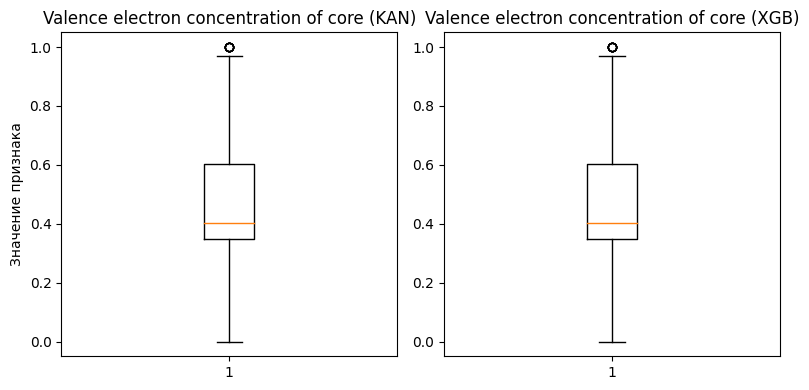

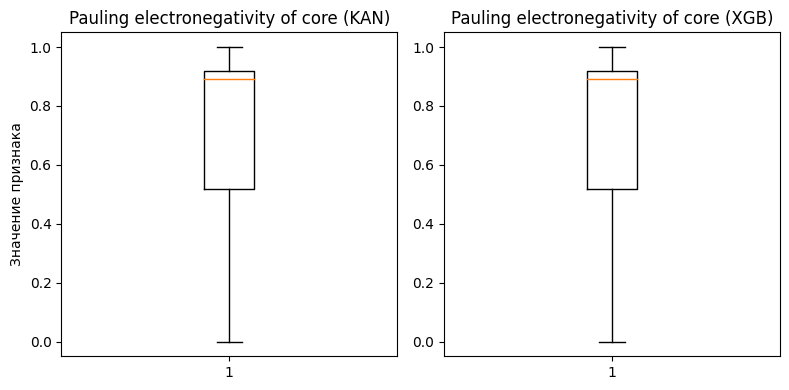

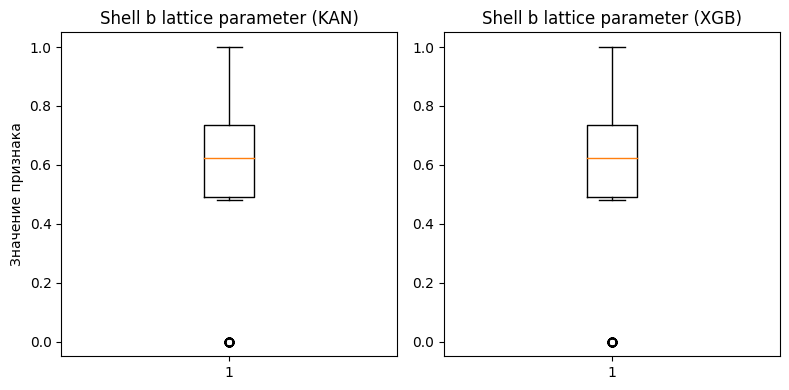

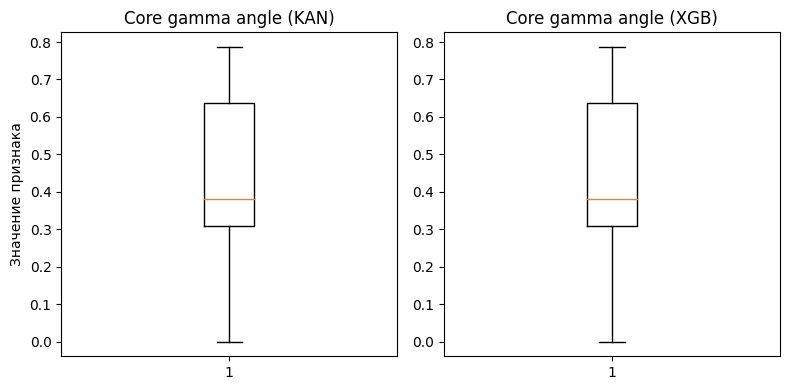

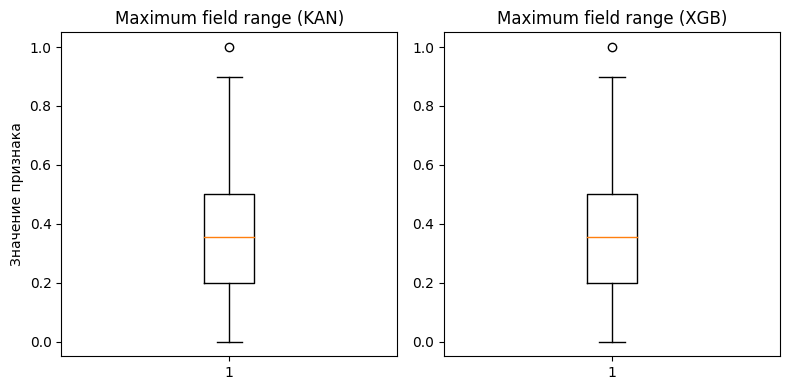

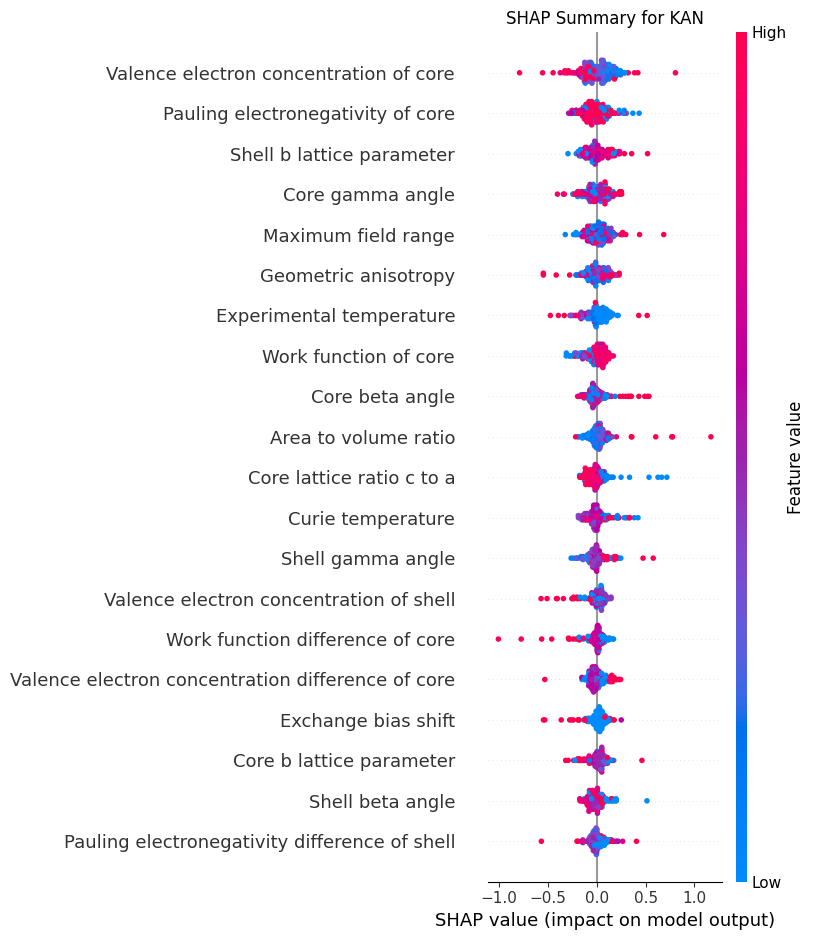

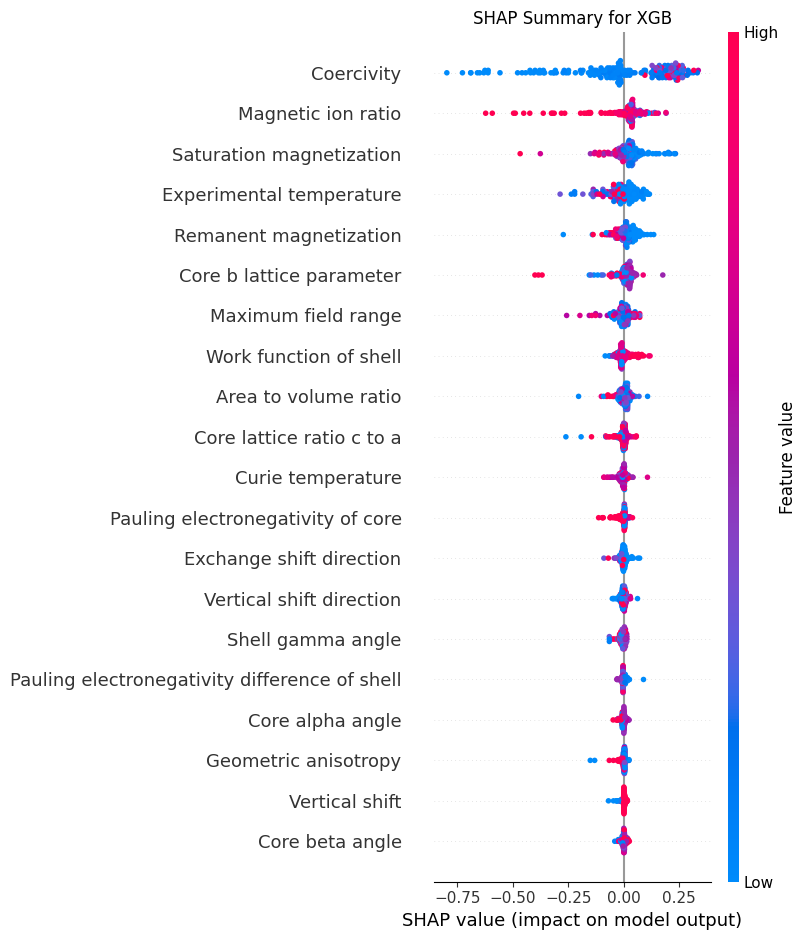

In [ ]:
# ---------- SHAP для KAN ----------

# Преобразуем SHAP значения KAN в numpy array, если еще не сделано
if isinstance(shap_values, list):
    shap_values_kan_np = np.array(shap_values[0])
else:
    shap_values_kan_np = np.array(shap_values)

# Если SHAP значения многомерные, усредняем по выходам
if shap_values_kan_np.ndim == 3:
    shap_values_kan_np = shap_values_kan_np.mean(axis=2)

# Получаем важность признаков для KAN как среднее абсолютное SHAP значение
feature_importance_kan = np.mean(np.abs(shap_values_kan_np), axis=0)

# ---------- Проверка длины массивов ----------

print("Length of renamed_features:", len(renamed_features))
print("Length of feature_importance_kan:", len(feature_importance_kan))

# Выводим список признаков для KAN
kan_features = [rename_dict.get(f'Feature {i}', f'Feature {i}') for i in range(len(feature_importance_kan))]
print("Features in KAN:", kan_features)

# ---------- SHAP для XGB ----------

# Получаем SHAP значения для XGB
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)

# Важность признаков для XGB как среднее абсолютное SHAP значение
feature_importance_xgb = np.mean(np.abs(shap_values_xgb), axis=0)

# ---------- Проверка длины массивов ----------

print("Length of feature_importance_xgb:", len(feature_importance_xgb))

# Выводим список признаков для XGB
xgb_features = [rename_dict.get(f'Feature {i}', f'Feature {i}') for i in range(len(feature_importance_xgb))]
print("Features in XGB:", xgb_features)

# ---------- Сравнение важности признаков ----------

# Проверим, что длины совпадают
if len(renamed_features) == len(feature_importance_kan) == len(feature_importance_xgb):
    # Преобразуем важности признаков в DataFrame для удобства
    importance_df = pd.DataFrame({
        'Feature': renamed_features,
        'KAN Importance': feature_importance_kan,
        'XGB Importance': feature_importance_xgb
    })

    # Сортируем по важности признаков в KAN
    importance_df = importance_df.sort_values(by='KAN Importance', ascending=False)

    # Выводим важные признаки
    print(importance_df.head(10))
else:
    print("Длины массивов не совпадают. Проверьте входные данные.")
    # Выводим списки признаков для дальнейшего анализа
    print("KAN Feature Importances:", feature_importance_kan)
    print("XGB Feature Importances:", feature_importance_xgb)
    print("KAN Feature Names:", kan_features)
    print("XGB Feature Names:", xgb_features)

# ---------- Построение Box-Plot для ключевых признаков ----------

# Если DataFrame был создан, строим box plot
if 'importance_df' in locals():
    # Отбираем признаки, которые важны для обеих моделей (например, топ-5)
    top_features = importance_df['Feature'].head(5)

    # Построение box-plot для этих признаков
    for feature in top_features:
        feature_index = renamed_features.index(feature)  # Находим индекс признака

        plt.figure(figsize=(8, 4))

        # Построение box-plot для KAN
        plt.subplot(1, 2, 1)
        plt.boxplot(X_test_np[:, feature_index])
        plt.title(f'{feature} (KAN)')
        plt.ylabel('Значение признака')

        # Построение box-plot для XGB
        plt.subplot(1, 2, 2)
        plt.boxplot(X_test_scaled[:, feature_index])
        plt.title(f'{feature} (XGB)')

        plt.tight_layout()
        plt.show()

# ---------- SHAP Summary для KAN и XGB ----------

# Построение SHAP summary plot для KAN
plt.title('SHAP Summary for KAN')
shap.summary_plot(shap_values_kan_np, X_test_np, feature_names=renamed_features)
plt.show()

# Построение SHAP summary plot для XGB
plt.title('SHAP Summary for XGB')
shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=renamed_features)
plt.show()